In [1]:
import pandas as pd
import numpy as np

df=pd.read_excel("./data/Assignment 3 - timeseries_data.xlsx")

EDA

In [2]:
df.head()

,DATETIME,HB_NORTH (RTLMP),ERCOT (WIND_RTI),ERCOT (GENERATION_SOLAR_RT),ERCOT (RTLOAD),HOURENDING,MARKETDAY,PEAKTYPE,MONTH,YEAR
0,2017-01-01 01:00:00,23.3575,2155.31,0.0,29485.791355,1,2017-01-01,OFFPEAK,JANUARY,2017
1,2017-01-01 02:00:00,21.4650,2313.81,0.0,28911.565913,2,2017-01-01,OFFPEAK,JANUARY,2017
2,2017-01-01 03:00:00,20.7350,2587.68,0.0,28238.258175,3,2017-01-01,OFFPEAK,JANUARY,2017
3,2017-01-01 04:00:00,20.2700,2748.65,0.0,27821.000513,4,2017-01-01,OFFPEAK,JANUARY,2017
4,2017-01-01 05:00:00,20.1200,2757.49,0.0,27646.942413,5,2017-01-01,OFFPEAK,JANUARY,2017


In [3]:
df.tail()

,DATETIME,HB_NORTH (RTLMP),ERCOT (WIND_RTI),ERCOT (GENERATION_SOLAR_RT),ERCOT (RTLOAD),HOURENDING,MARKETDAY,PEAKTYPE,MONTH,YEAR
14982,2018-09-17 08:00:00,20.8600,3195.52,2.04,41902.24,8,2018-09-17,WDPEAK,SEPTEMBER,2018
14983,2018-09-17 09:00:00,22.7675,2605.50,111.59,43014.37,9,2018-09-17,WDPEAK,SEPTEMBER,2018
14984,2018-09-17 10:00:00,31.0600,2034.80,261.65,45782.55,10,2018-09-17,WDPEAK,SEPTEMBER,2018
14985,2018-09-17 11:00:00,29.6700,NaN,464.88,49431.13,11,2018-09-17,WDPEAK,SEPTEMBER,2018
14986,2018-09-17 12:00:00,33.6607,NaN,NaN,52347.25,12,2018-09-17,WDPEAK,SEPTEMBER,2018


In [4]:
df.shape

(14987, 10)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14987 entries, 0 to 14986
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   DATETIME                     14987 non-null  datetime64[ns]
 1   HB_NORTH (RTLMP)             14987 non-null  float64       
 2   ERCOT (WIND_RTI)             14982 non-null  float64       
 3   ERCOT (GENERATION_SOLAR_RT)  14983 non-null  float64       
 4   ERCOT (RTLOAD)               14987 non-null  float64       
 5   HOURENDING                   14987 non-null  int64         
 6   MARKETDAY                    14987 non-null  datetime64[ns]
 7   PEAKTYPE                     14987 non-null  object        
 8   MONTH                        14987 non-null  object        
 9   YEAR                         14987 non-null  int64         
dtypes: datetime64[ns](2), float64(4), int64(2), object(2)
memory usage: 1.1+ MB


In [6]:
df.describe()

,HB_NORTH (RTLMP),ERCOT (WIND_RTI),ERCOT (GENERATION_SOLAR_RT),ERCOT (RTLOAD),HOURENDING,YEAR
count,14987.000000,14982.000000,14983.000000,14987.000000,14987.000000,14987.000000
mean,25.766417,7532.436283,291.989714,42371.673703,12.495763,2017.415493
std,46.361945,3992.884834,370.914596,9874.339631,6.922309,0.492823
min,-17.860000,54.440000,0.000000,25566.511248,1.000000,2017.000000
25%,18.041250,4135.630000,0.000000,35431.636526,6.000000,2017.000000
50%,20.057500,7281.445000,22.150000,39934.007113,12.000000,2017.000000
75%,25.030000,10851.647500,608.635000,47873.100786,18.000000,2018.000000
max,2809.357500,20350.400000,1257.540000,73264.662123,24.000000,2018.000000


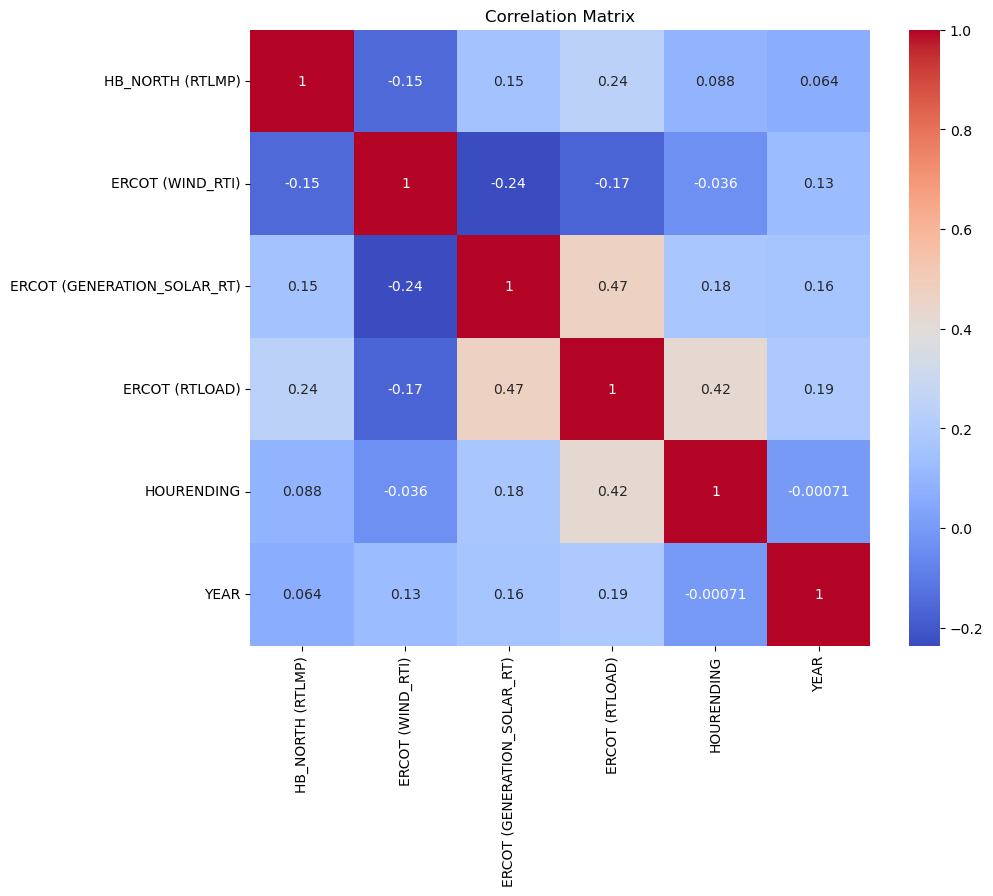

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr_matrix = df.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

We want to make sure the timestamps does not jump, so we could safely shift it

<AxesSubplot:>

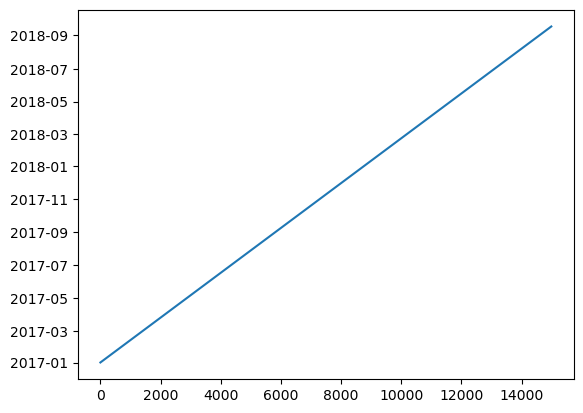

In [8]:
df["DATETIME"].plot()

We shift RTLMP -1 so that we use data from the last hour to predict next hour RTLMP
We make dummy variables for HOURENDING and PEAKTYPE as we believe it would affect the prediction accuracy
We convert the timestamp into integer so that it could be used in the prediction

In [9]:
df["y"]=df["HB_NORTH (RTLMP)"].shift(-1)

hour_dummy=pd.get_dummies(df['HOURENDING'])
hour_dummy.reset_index(inplace=True)
peak_dummy=pd.get_dummies(df['PEAKTYPE'])
peak_dummy.reset_index(inplace=True)
df=pd.concat([df, hour_dummy, peak_dummy], axis=1)

df["DATETIMEint"]=pd.to_datetime(df["DATETIME"]).astype(np.int64)/100000000000
df.dropna(inplace=True)

In [10]:
y=df["y"]

We choose our features to form X, and preprocessed it with StandardScaler so it works better in models

In [11]:
#to_drop=["y","DATETIME","HOURENDING","PEAKTYPE","MARKETDAY","MONTH","YEAR"]
to_drop=["y","DATETIME","HOURENDING","PEAKTYPE","MARKETDAY","MONTH","YEAR"]
X=df.copy()
for e in to_drop:
    X=X.drop(e, axis=1)   
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled,columns=X.columns)

C:\Users\ethan\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\ethan\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [12]:
X_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14981 entries, 0 to 14980
Data columns (total 34 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   HB_NORTH (RTLMP)             14981 non-null  float64
 1   ERCOT (WIND_RTI)             14981 non-null  float64
 2   ERCOT (GENERATION_SOLAR_RT)  14981 non-null  float64
 3   ERCOT (RTLOAD)               14981 non-null  float64
 4   index                        14981 non-null  float64
 5   1                            14981 non-null  float64
 6   2                            14981 non-null  float64
 7   3                            14981 non-null  float64
 8   4                            14981 non-null  float64
 9   5                            14981 non-null  float64
 10  6                            14981 non-null  float64
 11  7                            14981 non-null  float64
 12  8                            14981 non-null  float64
 13  9               

In [13]:
def train_test_split(X_in,y_in,train_percent):
    cutoff=int(len(y_in)*train_percent)
    return X_in[:cutoff],X_in[cutoff:],y_in[:cutoff],y_in[cutoff:]
def plot_test(pred):
    import matplotlib.pyplot as plt
    plt.plot(range(len(y_test)), y_test, color='blue', label='Actual')
    plt.plot(range(len(y_test)), pred, color='red', label='Predicted')
    plt.xlabel('Data Point')
    plt.ylabel('Value')
    plt.title('Actual vs Predicted')
    plt.legend()
    plt.show()
def plot_train(pred):
    import matplotlib.pyplot as plt
    plt.plot(range(len(y_train)), y_train, color='blue', label='Actual')
    plt.plot(range(len(y_train)), pred, color='red', label='Predicted')
    plt.xlabel('Data Point')
    plt.ylabel('Value')
    plt.title('Actual vs Predicted')
    plt.legend()
    plt.show()

Since the data is a time series data, we do not use random split for training, validation and testing sets, indstead we split it by time.

In [14]:
X_t,X_test,y_t,y_test=train_test_split(X_scaled,y,0.8)
X_train,X_val,y_train,y_val=train_test_split(X_t,y_t,0.9)

We tried Linear Regression to get an idea of a baseline prediction should look like, it has a mse of 4046 on the test set.
By plotting out the prediction on train sets, we figure out that the linear regression does not do well on predicting RTLMP outliers.

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Create and fit the linear regression model
regressor = LinearRegression()
regressor.fit(X_t, y_t)

# Predict on the test set
y_pred = regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 4046.628390076685


C:\Users\ethan\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\ethan\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


C:\Users\ethan\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


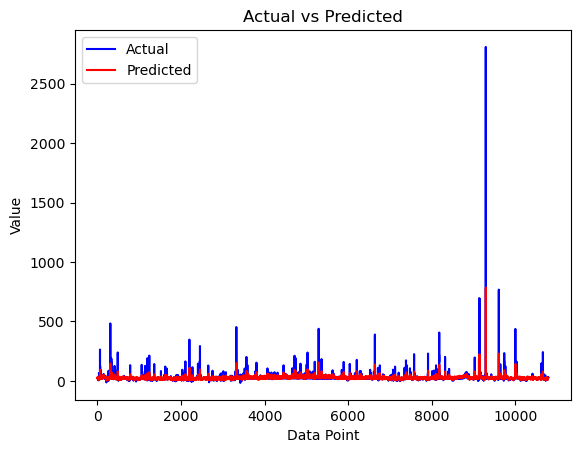

In [16]:
plot_train(regressor.predict(X_train))

By the insight we get from linear regression, we believe that when we try a NN model, a more complicated model would do better in predicting the outliers, while a more simple model would do better in predicting non-outliers. Thus we decide to create three NN models with different level of complexity and ensemble them to form our final prediction.
By plotting the training set predictions, our models are doing exactly what we expected. Further more, the MSE of the ensemble model is much better than the Linear Regression model.

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.ensemble import VotingRegressor

def create_model1(): #captures outliers well
    model = Sequential()
    model.add(Dense(units=256, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(units=128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(units=128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(units=64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(units=64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(units=32, activation='relu'))
    model.add(Dense(units=32, activation='relu'))
    model.add(Dense(units=16, activation='relu'))
    model.add(Dense(units=1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def create_model2():
    model = Sequential()
    model.add(Dense(units=64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(units=64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(units=32, activation='relu'))
    model.add(Dense(units=16, activation='relu'))
    model.add(Dense(units=1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def create_model3(): #captures non-outliers well
    model = Sequential()
    model.add(Dense(units=32, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dense(units=16, activation='relu'))
    model.add(Dense(units=1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Create instances of the three deep learning models
model1 = create_model1()
model2 = create_model2()
model3 = create_model3()


# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Fit and apply early stopping to each individual model in the ensemble
model1.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])
model2.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])
model3.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Predict a certain value with the ensemble model
prediction = np.mean([model1.predict(X_test), model2.predict(X_test), model3.predict(X_test)], axis=0)
pred1 = model1.predict(X_test)
pred2 = model2.predict(X_test)
pred3 = model3.predict(X_test)

# Evaluate the model
msenn = mean_squared_error(y_test, prediction)
print("Mean Squared Error ensemble:", msenn)
mse1 = mean_squared_error(y_test, pred1)
print("Mean Squared Error model1:", mse1)
mse2 = mean_squared_error(y_test, pred2)
print("Mean Squared Error model2:", mse2)
mse3 = mean_squared_error(y_test, pred3)
print("Mean Squared Error model3:", mse3)

Epoch 1/100
338/338 [==============================] - 5s 8ms/step - loss: 1257.7383 - val_loss: 383.5362
Epoch 2/100
338/338 [==============================] - 2s 5ms/step - loss: 1170.1747 - val_loss: 428.8898
Epoch 3/100
338/338 [==============================] - 2s 4ms/step - loss: 1160.4174 - val_loss: 1139.8914
Epoch 4/100
338/338 [==============================] - 2s 5ms/step - loss: 1149.3972 - val_loss: 354.0672
Epoch 5/100
338/338 [==============================] - 2s 6ms/step - loss: 1127.7761 - val_loss: 519.2991
Epoch 6/100
338/338 [==============================] - 2s 6ms/step - loss: 1109.3330 - val_loss: 383.6853
Epoch 7/100
338/338 [==============================] - 2s 6ms/step - loss: 1128.8370 - val_loss: 585.8691
Epoch 1/100
338/338 [==============================] - 3s 4ms/step - loss: 1338.1451 - val_loss: 368.7661
Epoch 2/100
338/338 [==============================] - 1s 4ms/step - loss: 1146.6959 - val_loss: 339.1443
Epoch 3/100
338/338 [========================

338/338 [==============================] - 0s 1ms/step


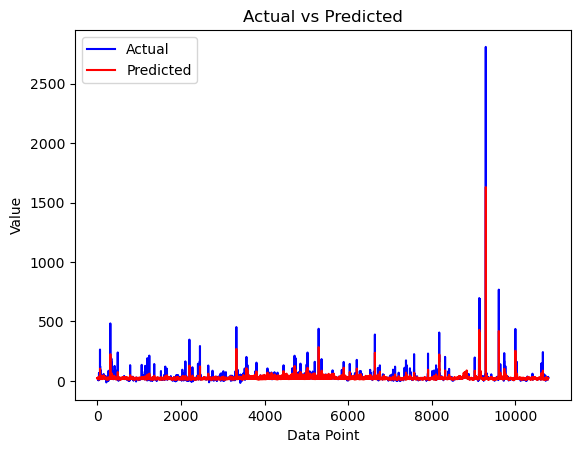

338/338 [==============================] - 1s 2ms/step


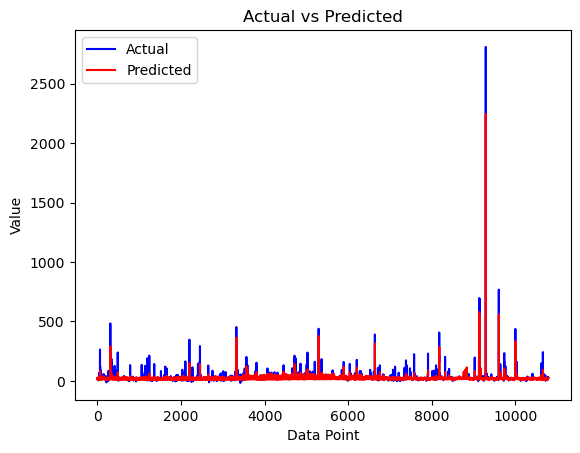

338/338 [==============================] - 1s 2ms/step


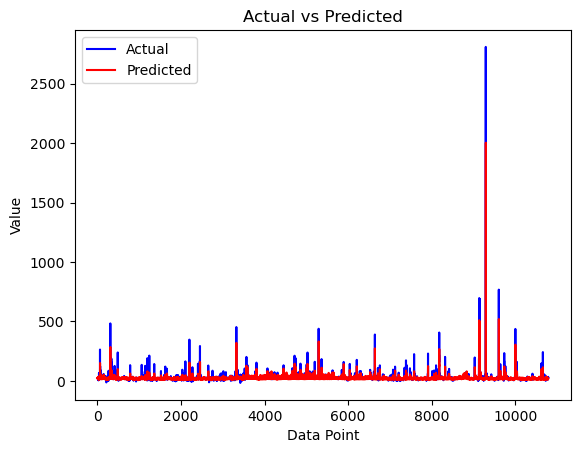

338/338 [==============================] - 1s 2ms/step


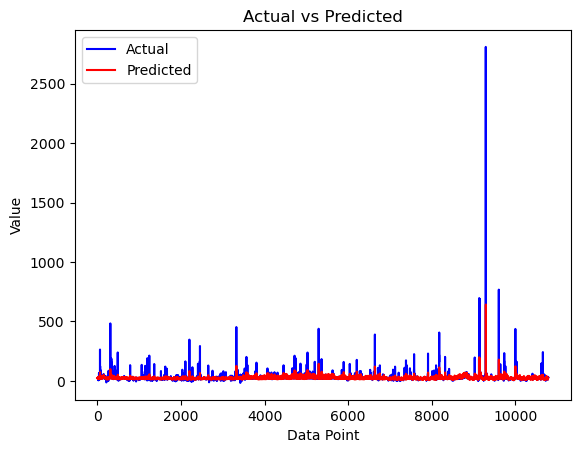

In [18]:
plot_train(np.mean([model1.predict(X_train), model2.predict(X_train), model3.predict(X_train)], axis=0))
plot_train(model1.predict(X_train))
plot_train(model2.predict(X_train))
plot_train(model3.predict(X_train))

We finally plot the Linear Regression and Ensemble NN model predictions on test set, as expected, the ensemble model not only has a better MSE, but also does better on outliers as we expected.

Test set prediction of Linear Regression
Mean Squared Error:  4046.628390076685


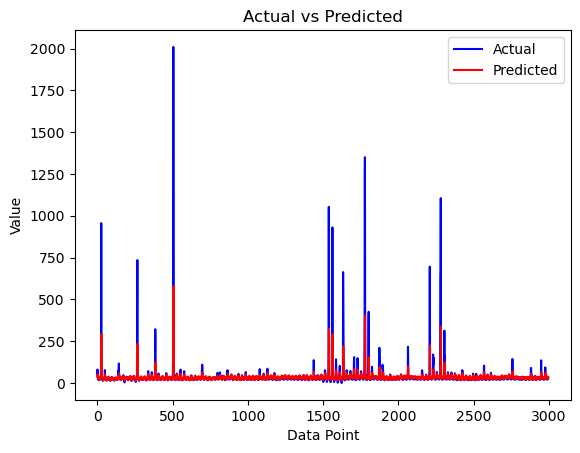

Test set prediction of Ensemble NN model
Mean Squared Error:  3228.68098694766


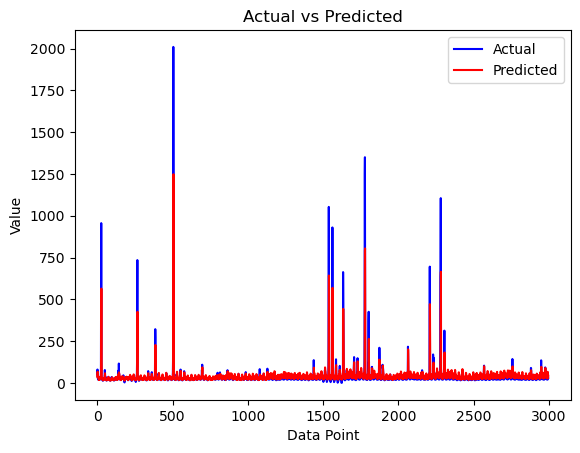

In [19]:
print("Test set prediction of Linear Regression")
print("Mean Squared Error: ", mse)
plot_test(y_pred)
print("Test set prediction of Ensemble NN model")
print("Mean Squared Error: ", msenn)
plot_test(prediction)